## Load Required Library

In [1]:
!pip install awswrangler
import awswrangler
print(awswrangler.__version__)

/opt/conda/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
You should consider upgrading via the '/opt/conda/bin/python -m pip install --upgrade pip' command.
2.15.1


In [2]:
# Create connection to the staging directory.
import boto3
import sagemaker
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
try:
    import awswrangler as wr   
except:
    !pip install awswrangler
    import awswrangler as wr  
    
try:
    from pyathena import connect
except:
    !pip install --disable-pip-version-check -q PyAthena==2.1.0
    from pyathena import connect

sess = sagemaker.Session()
bucket = sess.default_bucket()
role = sagemaker.get_execution_role()
region = boto3.Session().region_name

bucket = 'ads508team7'
raw_file_dir   = f"s3://{bucket}/raw_files"
s3_staging_dir = f"s3://{bucket}/athena/staging"
split_dir      = f"s3://{bucket}/split"
database_name  = 'sys'
conn = connect(region_name=region, s3_staging_dir=s3_staging_dir)

## Load each csv file

In [3]:
tr          = wr.s3.read_csv('{raw_file_dir}/{file_name}/{file_name}.csv'.format(raw_file_dir=raw_file_dir, file_name='order_products__train'))
pr          = wr.s3.read_csv('{raw_file_dir}/{file_name}/{file_name}.csv'.format(raw_file_dir=raw_file_dir, file_name='order_products__prior'))
orders      = wr.s3.read_csv('{raw_file_dir}/{file_name}/{file_name}.csv'.format(raw_file_dir=raw_file_dir, file_name='orders')) 
products    = wr.s3.read_csv('{raw_file_dir}/{file_name}/{file_name}.csv'.format(raw_file_dir=raw_file_dir, file_name='products')) 
departments = wr.s3.read_csv('{raw_file_dir}/{file_name}/{file_name}.csv'.format(raw_file_dir=raw_file_dir, file_name='departments')) 
pr_tr       = pd.concat([tr, pr])

In [4]:
# 80% of the data will be reserved for the trainset while 10% of the data will be reserved each for validation and testing, respectively. 
df_train     = pr_tr.sample(frac = 0.8, random_state=1)
df_remaining = pr_tr.loc[~pr_tr.index.isin(df_train.index)]
df_test      = df_remaining.sample(frac = 0.5, random_state=1)
df_validate  = df_remaining.loc[~df_remaining.index.isin(df_test.index)]

In [5]:
print('Total of {:,} number records were present.'.format(len(pr_tr)))
print('df_train has {:,} ({:.0%})number of records.'.format(len(df_train),len(df_train)/len(pr_tr)))
print('df_test has {:,} ({:.0%})number of records.'.format(len(df_test),len(df_test)/len(pr_tr)))
print('df_validate has {:,} ({:.0%}) number of records.'.format(len(df_validate),len(df_validate)/len(pr_tr)))
del pr_tr

Total of 33,819,106 number records were present.
df_train has 27,055,285 (80%)number of records.
df_test has 3,160,472 (9%)number of records.
df_validate has 3,132,715 (9%) number of records.


In [6]:
def add_department_name(df, save_to_path):
    
    df = df.join(products[['product_id','department_id']].set_index('product_id'), on='product_id')
    df = df.join(departments.set_index('department_id'), on='department_id')
    df.drop(['department_id'], axis = 1, inplace = True)     
    wr.s3.to_csv(df, save_to_path, index = False)
    print('File saved in: ',save_to_path)

save_to_path = 's3://{bucket}/{file_name}/{file_name}.csv'.format(bucket= bucket, split_dir=split_dir, file_name='unbalance')
add_department_name(df_train,save_to_path)

save_to_path = '{split_dir}/{file_name}/{file_name}.csv'.format(split_dir=split_dir, file_name='test')
add_department_name(df_test,save_to_path)

save_to_path = '{split_dir}/{file_name}/{file_name}.csv'.format(split_dir=split_dir, file_name='validate')
add_department_name(df_validate,save_to_path)

File saved in:  s3://ads508team7/unbalance/unbalance.csv
File saved in:  s3://ads508team7/split/test/test.csv
File saved in:  s3://ads508team7/split/validate/validate.csv


Setup a dataframe that will be balanced train set

In [7]:
unbalance_path = 's3://{bucket}/{file_name}/{file_name}.csv'.format(bucket= bucket, split_dir=split_dir, file_name='unbalance')
unbalance      = wr.s3.read_csv(unbalance_path) 
print(unbalance.shape)
unbalance.head()

(27055285, 5)


,order_id,product_id,add_to_cart_order,reordered,department
0,460355,32959,25,1,meat seafood
1,1138671,7503,24,1,snacks
2,2788052,44471,4,0,babies
3,1772534,260,3,0,produce
4,1187180,26209,5,1,produce


## Get Proportation of Re-ordered Items Per Department

In [8]:
# count how many products where sold per each department

def groupby_dept(df):
    df_groupby_dept = pd.DataFrame()

    for dept in df.department.unique():
        dept_count = df.query('department == @dept').shape[0]      
        reordered_count =  df.query('department == @dept and reordered == 1').shape[0]      

        df_groupby_dept.loc[dept,'qty_sold']           = dept_count
        df_groupby_dept.loc[dept,'reordered']          = reordered_count
        df_groupby_dept.loc[dept,'not_reordered']      = dept_count - reordered_count
        df_groupby_dept.loc[dept,'reordered_perc']     = (reordered_count / dept_count) * 100
        df_groupby_dept.loc[dept,'not_reordered_perc'] = ((dept_count - reordered_count) / dept_count * 100)                   


    cols_int = ['qty_sold', 'reordered', 'not_reordered']
    df_groupby_dept[cols_int] = df_groupby_dept[cols_int].astype('int32')

    for col in ['not_reordered_perc','reordered_perc']:
        df_groupby_dept[col] = df_groupby_dept[col].map('{:.1f}'.format)

    df_groupby_dept = df_groupby_dept.sort_values('qty_sold', ascending=False)
    return df_groupby_dept


df_tr_dept = groupby_dept(unbalance)
df_tr_dept.head()

,qty_sold,reordered,not_reordered,reordered_perc,not_reordered_perc
produce,7911891,5146659,2765232,65.0,35.0
dairy eggs,4505840,3019740,1486100,67.0,33.0
snacks,2403546,1380781,1022765,57.4,42.6
beverages,2244220,1467048,777172,65.4,34.6
frozen,1869974,1014600,855374,54.3,45.7


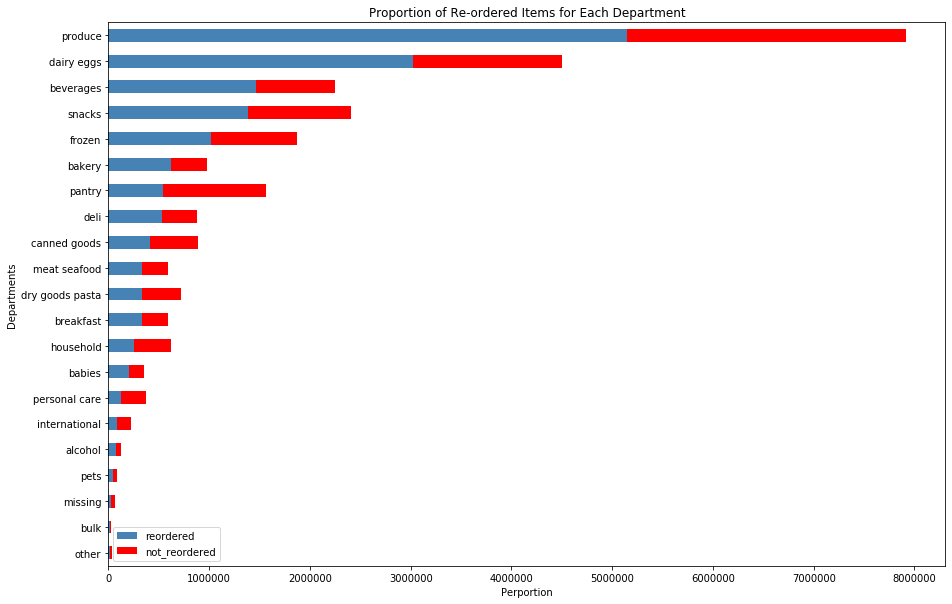

In [9]:
data_to_plot = df_tr_dept[['reordered','not_reordered']].sort_values(by=["reordered"]) 

data_to_plot.plot(kind='barh', stacked=True, color=['steelblue', 'red'], figsize=(15, 10), legend= 6)

plt.ylabel('Departments')
plt.xlabel('Perportion')
plt.title('Proportion of Re-ordered Items for Each Department')
plt.show()

## Balance the Dataset by Department and Re-order Classification

In [20]:
least_records = min(df_tr_dept.reordered.min(), df_tr_dept.not_reordered.min())

query_temp = "department == '{departmnet}' and reordered == {classification}"

df_balanced = pd.DataFrame()
for departmnet in df_tr_dept.index.tolist():
    for classification in [0,1]:
        query_temp = f"department == '{departmnet}' and reordered == {classification}"
        df_dept_class = unbalance.query(query_temp).sample(least_records)
        df_balanced = pd.concat([df_balanced, df_dept_class])
        print(f"Departmnet '{departmnet}' with reordered as '{classification}' was added to balanced dataframe.")

print(df_balanced.shape)
df_balanced.head()

Departmnet 'produce' with reordered as '0' was added to balanced dataframe.
Departmnet 'produce' with reordered as '1' was added to balanced dataframe.
Departmnet 'dairy eggs' with reordered as '0' was added to balanced dataframe.
Departmnet 'dairy eggs' with reordered as '1' was added to balanced dataframe.
Departmnet 'snacks' with reordered as '0' was added to balanced dataframe.
Departmnet 'snacks' with reordered as '1' was added to balanced dataframe.
Departmnet 'beverages' with reordered as '0' was added to balanced dataframe.
Departmnet 'beverages' with reordered as '1' was added to balanced dataframe.
Departmnet 'frozen' with reordered as '0' was added to balanced dataframe.
Departmnet 'frozen' with reordered as '1' was added to balanced dataframe.
Departmnet 'pantry' with reordered as '0' was added to balanced dataframe.
Departmnet 'pantry' with reordered as '1' was added to balanced dataframe.
Departmnet 'bakery' with reordered as '0' was added to balanced dataframe.
Departmne

,order_id,product_id,add_to_cart_order,reordered,department
13662223,1046322,15143,6,0,produce
22646699,1358195,47626,10,0,produce
21127685,1518614,24964,5,0,produce
1215557,1993559,44683,18,0,produce
24117060,1414387,28842,20,0,produce


Verify that department has equal number of records with 50% reordered and 50% not-reordered



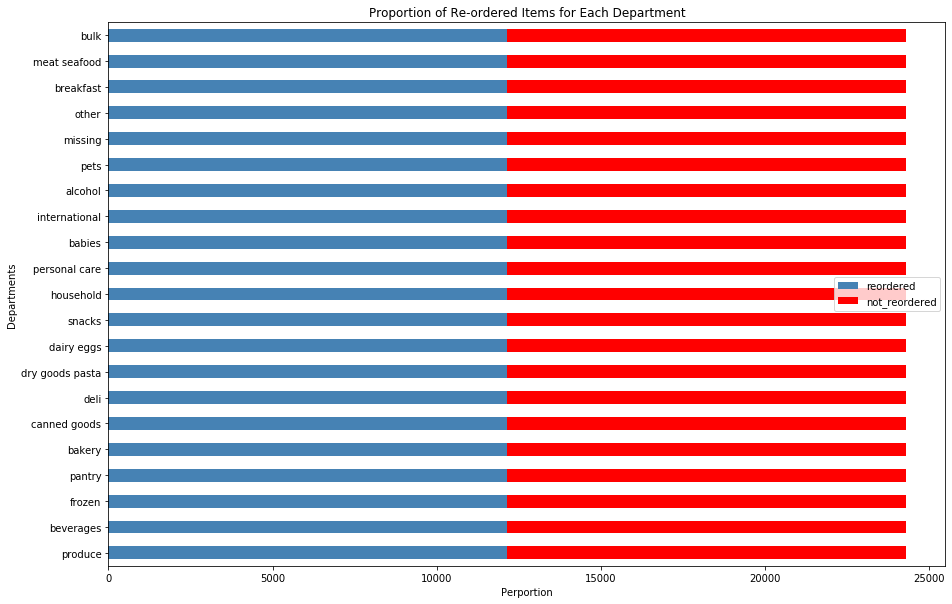

In [21]:
print('Verify that department has equal number of records with 50% reordered and 50% not-reordered\n')


balanced_dept_groupby = groupby_dept(df_balanced)

data_to_plot = balanced_dept_groupby[['reordered','not_reordered']].sort_values(by=["reordered"]) 

data_to_plot.plot(kind='barh', stacked=True, color=['steelblue', 'red'], figsize=(15, 10), legend= 6)

plt.ylabel('Departments')
plt.xlabel('Perportion')
plt.title('Proportion of Re-ordered Items for Each Department')
plt.show()

In [22]:
# save balanced data frame in s3 to be used for future notebooks
save_to_path = f's3://{bucket}/balanced/balanced.csv'
wr.s3.to_csv(df_balanced, save_to_path, index = False)

{'paths': ['s3://ads508team7/balanced/balanced.csv'], 'partitions_values': {}}